In [2]:
# prompt: mount to drive, cd to summer 2024/group project

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# %cd /content/drive/MyDrive/summer2024/group\ project

## Load and Review Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
data = pd.read_csv('cleaned_data.csv')
# data = pd.read_csv('sandiego_listings.csv')
print(data.columns)
data.head()

Index(['latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm'],
      dtype='object')


,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0,35.57864,-82.59578,0,95.0,1,423,2.75,7,251,40
1,35.57864,-82.59578,1,66.0,1,67,0.44,7,159,0
2,35.57864,-82.59578,2,26.0,1,338,2.21,7,271,16
3,35.57735,-82.63804,1,45.0,2,80,0.56,2,76,14
4,35.61736,-82.55074,0,100.0,30,63,0.41,1,208,4


In [11]:
# data = data.drop(columns=['neighbourhood_group', 'neighbourhood', 'license', 'name', 'id', 'name', 'host_id', 'host_name', 'last_review'])

KeyError: "['neighbourhood_group', 'neighbourhood', 'license', 'name', 'id', 'name', 'host_id', 'host_name', 'last_review'] not found in axis"

In [12]:
data['room_type'].value_counts()

room_type
0    131766
1     41544
2      1585
3       377
Name: count, dtype: int64

In [40]:
room_type_dict = {'Entire home/apt':0, 'Private room':1, 'Shared room': 2, 'Hotel room':3}
data['room_type'] = data['room_type'].replace(room_type_dict)
data['room_type'].value_counts()

C:\Users\sangd\AppData\Local\Temp\ipykernel_12020\2477849265.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['room_type'] = data['room_type'].replace(room_type_dict)


room_type
0    9846
1    1573
2      68
3       9
Name: count, dtype: int64

In [13]:
data.describe().round(3)

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,175272.000,175272.000,175272.000,175272.000,175272.000,175272.000,175272.000,175272.000,175272.000,175272.000
mean,34.899,-105.126,0.262,180.085,11.467,41.398,1.213,7.831,206.094,9.818
std,6.730,24.547,0.473,118.222,13.196,69.269,1.317,11.750,116.463,12.169
min,18.930,-159.708,0.000,5.000,1.000,0.000,0.000,1.000,0.000,0.000
25%,32.700,-118.468,0.000,93.000,2.000,2.000,0.150,1.000,96.000,0.000
50%,35.584,-114.950,0.000,149.000,3.000,13.000,0.770,2.000,219.000,4.000
75%,40.672,-80.237,0.000,237.000,30.000,49.000,1.990,8.000,315.000,16.000
max,47.734,-71.001,3.000,589.000,59.000,966.000,24.130,57.000,365.000,46.000


## Add income_group

### 1. calculate income

In [15]:
# create column income
data['income'] = data['price'] * data['minimum_nights'] * data['reviews_per_month']

<Axes: >

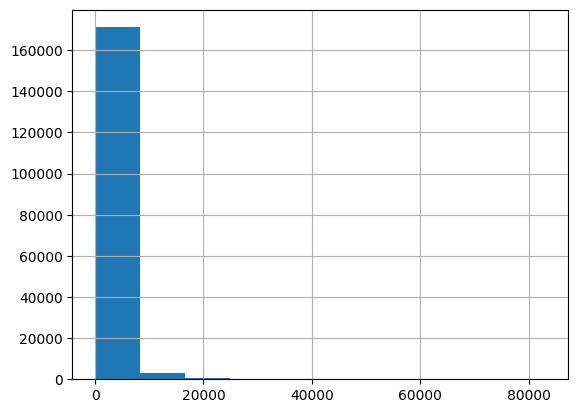

In [16]:
data['income'].hist()

### crop some outliners

Seem like the data is still very skewed, we're gonna crop some outliners

In [17]:
def remove_outliers_iqr(df, columns, th1=0.01, th3=0.90, multiplier=1.5):
    for column in columns:
        Q1 = df[column].quantile(th1)
        Q3 = df[column].quantile(th3)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        print(f"column: {column}, lower_bound: {lower_bound}, upper_bound: {upper_bound}")
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

data = remove_outliers_iqr(data, ['income'], th1=0.1, th3 = 0.80)

column: income, lower_bound: -1980.0, upper_bound: 3300.0


count    162443.000000
mean        587.735301
std         685.323667
min           0.000000
25%          64.000000
50%         348.000000
75%         851.610000
max        3300.000000
Name: income, dtype: float64

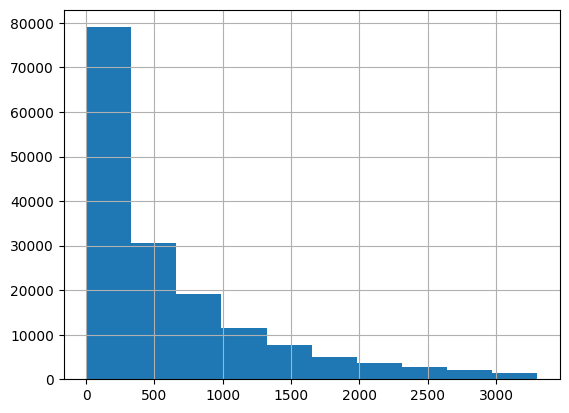

In [18]:
data['income'].hist()
data['income'].describe()

### income_group

It'd be good to divide the group based on the percentiles. This would allows the group proportion to be equal, and the values look quite reasonable

In [19]:
first_quartile = data['income'].quantile(0.25)
second_quartile = data['income'].quantile(0.5)
third_quartile = data['income'].quantile(0.75)
fourth_quartile = data['income'].quantile(1)

data['income_group'] = data['income'].apply(lambda x: 0 if x < first_quartile else 1 if x < second_quartile else 2 if x < third_quartile else 3)

# data['income_group'] = data['income'].apply(lambda x: 0 if x < 750 else 1 if x < 1500 else 2 if x < 2250 else 3)

data['income_group'].value_counts()



C:\Users\sangd\AppData\Local\Temp\ipykernel_19000\1748987920.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['income_group'] = data['income'].apply(lambda x: 0 if x < first_quartile else 1 if x < second_quartile else 2 if x < third_quartile else 3)


income_group
2    40639
3    40611
1    40605
0    40588
Name: count, dtype: int64

## Data Prep

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

In [21]:
new_data = data.drop(columns=['income', 'reviews_per_month','number_of_reviews','number_of_reviews_ltm'])

### Scaling

some features use StandardScaler, some use MinMaxscaler

In [22]:
# standardization
# standardized_cols = ['latitude', 'longitude']  # we use stardard scaler for these columns because there are negative values here

# standard_scaler = StandardScaler()

# new_data[standardized_cols] = standard_scaler.fit_transform(data[standardized_cols])

# minmax normalization
minmax_cols = ['room_type', 'price' ,'minimum_nights', 	'calculated_host_listings_count','availability_365','latitude', 'longitude', 'income_group']

min_max_scaler = MinMaxScaler()

new_data[minmax_cols] = min_max_scaler.fit_transform(data[minmax_cols])

In [23]:
new_data.describe()

,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365,income_group
count,162443.000000,162443.000000,162443.000000,162443.000000,162443.000000,162443.000000,162443.000000,162443.000000
mean,0.549733,0.610418,0.090108,0.294411,0.159223,0.126584,0.562672,0.500106
std,0.234783,0.275085,0.159733,0.199598,0.219077,0.213352,0.320485,0.372638
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.398172,0.464726,0.000000,0.147260,0.000000,0.000000,0.254795,0.333333
50%,0.546540,0.503046,0.000000,0.239726,0.017241,0.035714,0.600000,0.666667
75%,0.753210,0.869741,0.333333,0.388699,0.500000,0.142857,0.863014,0.833333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
# income_group and room_type are orginilly categorical, then discrete data, just want to check if they're still are
print(new_data['income_group'].value_counts())
print(new_data['room_type'].value_counts())

income_group
0.666667    40639
1.000000    40611
0.333333    40605
0.000000    40588
Name: count, dtype: int64
room_type
0.000000    120792
0.333333     39759
0.666667      1523
1.000000       369
Name: count, dtype: int64


### Split data to train and test, one hot encode target

In [25]:
X = new_data.drop(columns=['income_group']).values
y = new_data['income_group'].values

#OHE
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) #
y_onehot = encoder.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

## Model

In [26]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import L2

### Hyperparameters

In [36]:
input_size = X_train.shape[1]
num_classes = y_train.shape[1]
batch_size = 1000
epochs = 200
learning_rate = 0.001

### Model Init

In [47]:
model = Sequential()
model.add(Dense(512, activation='tanh', input_shape=(input_size,))) #, kernel_regularizer=L2(0.01)
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu')) #,kernel_regularizer=L2(0.01)
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu')) #,kernel_regularizer=L2(0.01)
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               4096      
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 256)              

## Train

In [48]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), verbose=1, callbacks=[callback]) #

Epoch 1/200
130/130 [==============================] - 3s 19ms/step - loss: 1.2311 - accuracy: 0.4194 - val_loss: 1.1919 - val_accuracy: 0.4454
Epoch 2/200
130/130 [==============================] - 2s 18ms/step - loss: 1.1909 - accuracy: 0.4452 - val_loss: 1.1681 - val_accuracy: 0.4582
Epoch 3/200
130/130 [==============================] - 2s 19ms/step - loss: 1.1744 - accuracy: 0.4534 - val_loss: 1.1655 - val_accuracy: 0.4582
Epoch 4/200
130/130 [==============================] - 2s 18ms/step - loss: 1.1632 - accuracy: 0.4599 - val_loss: 1.1535 - val_accuracy: 0.4651
Epoch 5/200
130/130 [==============================] - 2s 18ms/step - loss: 1.1581 - accuracy: 0.4645 - val_loss: 1.1480 - val_accuracy: 0.4687
Epoch 6/200
130/130 [==============================] - 2s 18ms/step - loss: 1.1532 - accuracy: 0.4676 - val_loss: 1.1454 - val_accuracy: 0.4725
Epoch 7/200
130/130 [==============================] - 2s 18ms/step - loss: 1.1495 - accuracy: 0.4680 - val_loss: 1.1457 - val_accuracy:

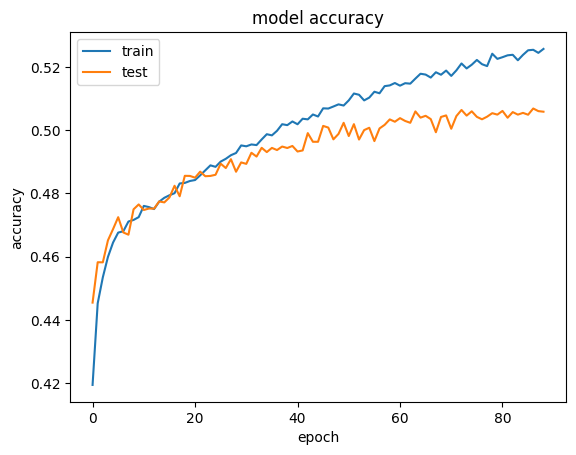

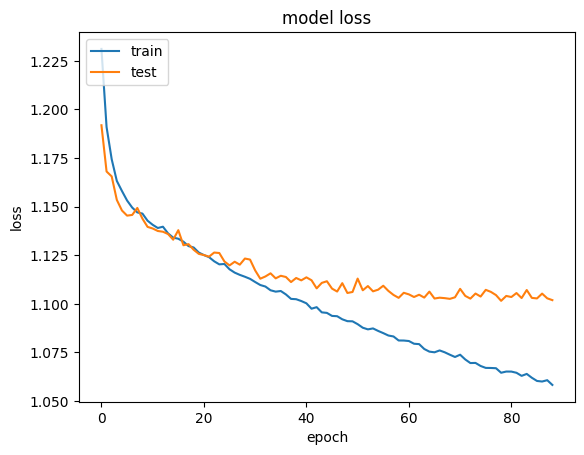

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
yhat_test = model.predict(X_test).round(3)
yhat_test_idx = np.argmax(yhat_test, axis=1)
y_labels = y_test
y_labels_idx = np.argmax(y_labels, axis=1)
# print(yhat_test*100)
# for i in zip(yhat_test_idx, y_labels_idx):
#     print(i)

1016/1016 [==============================] - 1s 1ms/step


## Result

We predict the income group of 10 random samples. The accuracy is about 50% as expected. Even when the model predict the income group wrongly, the actual income group still have a decent likelyhood, it usually get the second highest likely hood, if not the best.

1/1 [==============================] - 0s 16ms/step
predict%: [22.1 48.2 21.8  8. ] = 1 | actual: 1 | %ofActual: 48.20000076293945


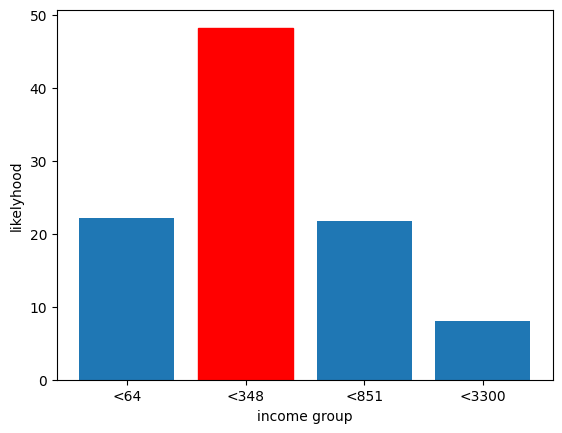

predict%: [47.8      23.       15.800001 13.400001] = 0 | actual: 1 | %ofActual: 23.0


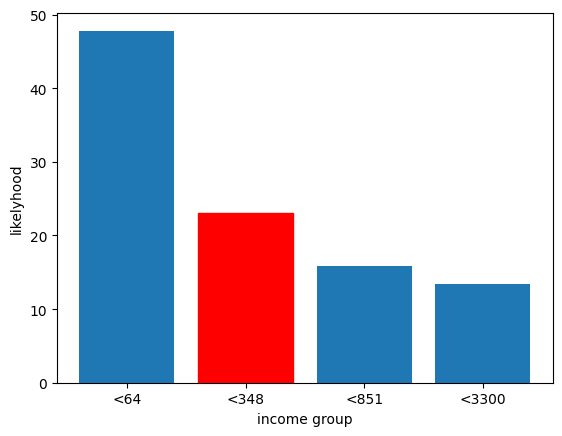

predict%: [32.8        6.8999996 15.099999  45.100002 ] = 3 | actual: 0 | %ofActual: 32.79999923706055


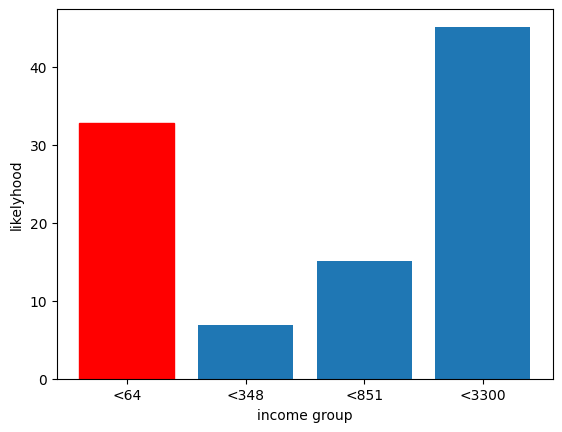

predict%: [ 5.5      15.299999 26.       53.2     ] = 3 | actual: 2 | %ofActual: 26.0


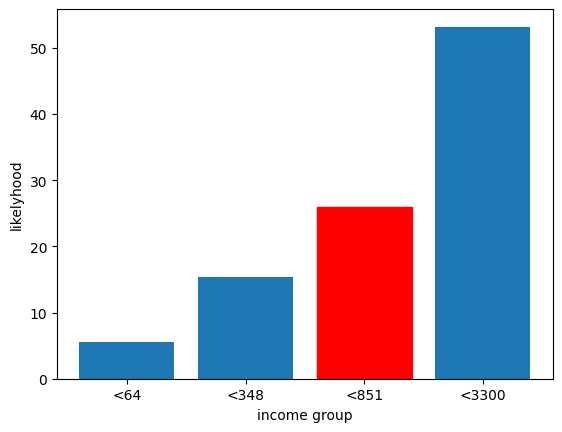

predict%: [ 3.2 25.2 65.3  6.3] = 2 | actual: 2 | %ofActual: 65.30000305175781


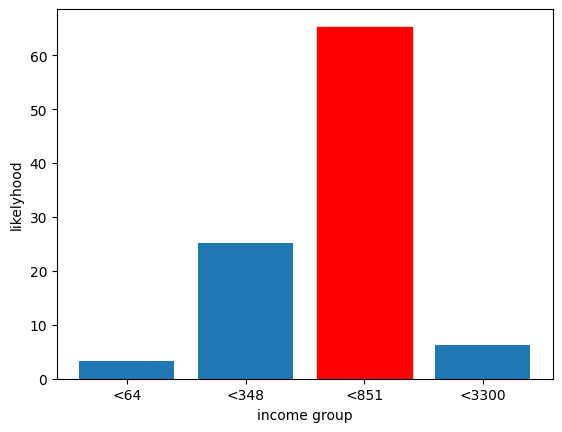

predict%: [71.5      13.799999 10.599999  4.2     ] = 0 | actual: 0 | %ofActual: 71.5


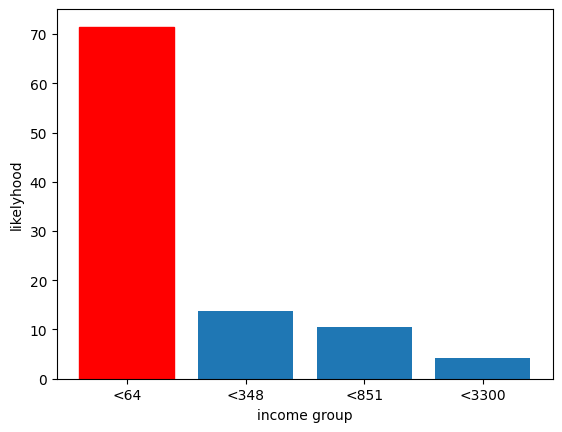

predict%: [96.3  3.7  0.   0. ] = 0 | actual: 0 | %ofActual: 96.30000305175781


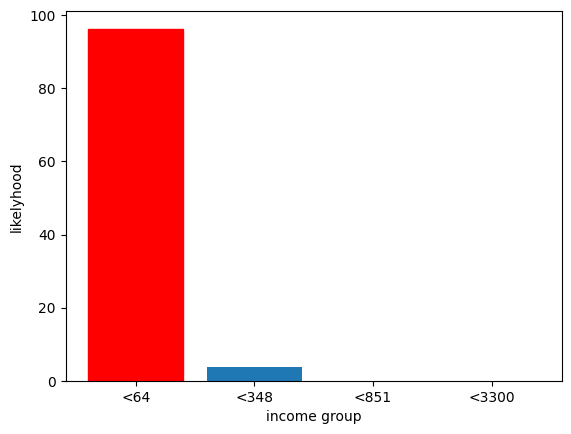

predict%: [15.700001 15.099999 26.199999 43.      ] = 3 | actual: 3 | %ofActual: 43.0


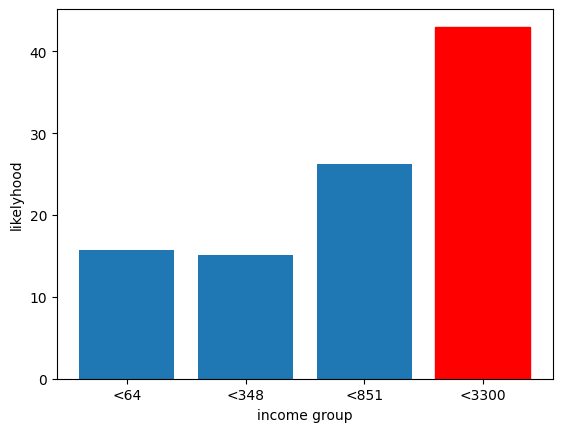

predict%: [34.6  9.3 20.2 35.9] = 3 | actual: 3 | %ofActual: 35.900001525878906


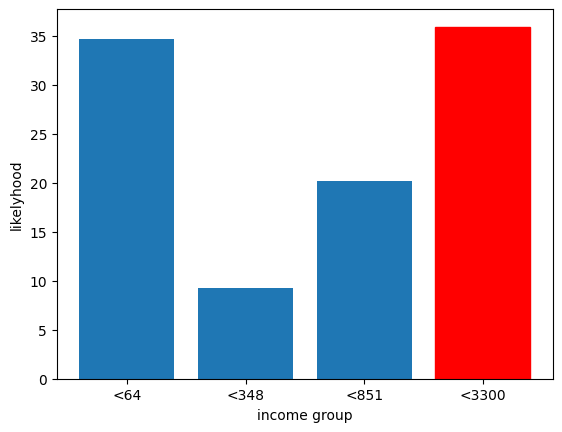

predict%: [ 8.4 23.6 46.1 21.9] = 2 | actual: 3 | %ofActual: 21.899999618530273


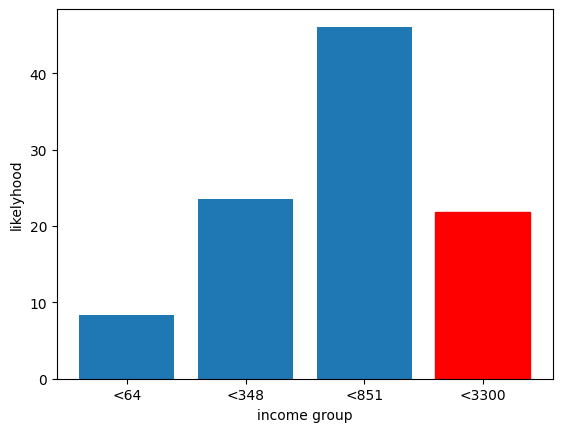

In [56]:
def predict(idx, r):
    yhat_test = model.predict(X_test[idx:idx+r]).round(3)
    yhat_test_idx = np.argmax(yhat_test, axis=1)
    y_labels = y_test[idx:idx+r]
    y_labels_idx = np.argmax(y_labels, axis=1)
    # print(yhat_test*100)
    for i in zip(yhat_test*100, yhat_test_idx, y_labels_idx):
        print(f"predict%: {i[0]} = {i[1]} | actual: {i[2]} | %ofActual: {i[0][i[2]]}")
        barlist = plt.bar(['<64', '<348', '<851', '<3300'], i[0])
        barlist[i[2]].set_color('r')
        plt.xlabel('income group')
        plt.ylabel('likelyhood')
        plt.show()
predict(2984, 10)

<Axes: >

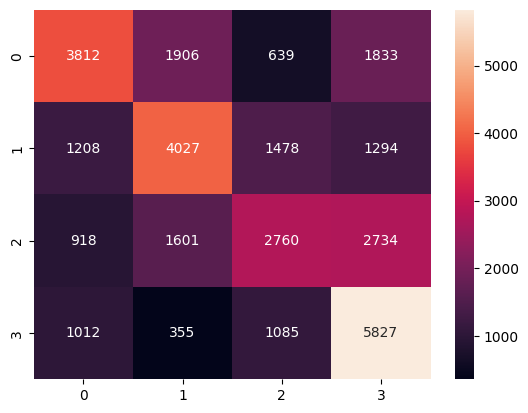

In [45]:
cm = confusion_matrix(y_labels_idx, yhat_test_idx)
sns.heatmap(cm, annot=True, fmt='d')

In [46]:
print(classification_report(y_labels_idx, yhat_test_idx))

              precision    recall  f1-score   support

           0       0.55      0.47      0.50      8190
           1       0.51      0.50      0.51      8007
           2       0.46      0.34      0.39      8013
           3       0.50      0.70      0.58      8279

    accuracy                           0.51     32489
   macro avg       0.51      0.50      0.50     32489
weighted avg       0.51      0.51      0.50     32489



## Save Model

In [27]:
model.save('c_model.keras')

In [28]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


## Cross-validation (probably not necessary, since our accuracy is pretty high)

# Suggesting Model

### TODO:
  1. Write script that asks for user input
  2. redo StardardScaler and MinMaxScaler, we need to record the meand and std of each column, so we can stardardize and normalize user input manually
  3. Feed user input to Price Predicting model, get price range
  4. For each price, feed user input + price to this classification model
  5. Report the likelyhood of monthly income, suggest ideal price of the listing